In [4]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 4.2 MB/s eta 0:00:01


In [10]:
import gc
import glob
import os
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from IPython.display import display

from joblib import delayed, Parallel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook as tqdm


%matplotlib inline

DATA_DIR = '/home/steven/av_data/input'

# data configurations
USE_PRECOMPUTE_FEATURES = False  # Load precomputed features for train.csv from private dataset (just for speed up)

# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.185
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# for saving quota
IS_1ST_STAGE = False
SHORTCUT_NN_IN_1ST_STAGE = False  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization


@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')
    
def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

In [6]:
!pip -q install /home/steven/av_data/input/pytorchtabnet/pytorch_tabnet-2.0.1-py3-none-any.whl

In [12]:
!pip install pyarrow

     |████████████████████████████████| 34.9 MB 30.1 MB/s eta 0:00:01


In [7]:
train = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'train.csv'))
stock_ids = set(train['stock_id'])

## Feature Engineering

### Base Features

In [13]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3


def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', directory, f'stock_id={stock_id}'))


def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)


def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap


def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


def make_book_feature(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))
    
    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id
    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_trade_feature(stock_id, block = DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id
        
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst


def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df


def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d

In [14]:
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather(os.path.join(DATA_DIR, 'optiver-df2', 'features_v2.f'))
else:
    df = make_features(train, DataBlock.TRAIN)
    # v2
    df = make_features_v2(df, DataBlock.TRAIN)

df.to_feather('features_v2.f')  # save cache

test = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'test.csv'))
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True

if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)
    test_df = make_features_v2(test_df, DataBlock.TEST)

print(df.shape)
print(test_df.shape)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

[books]  291.941sec
[trades]  45.119sec
[extra features]  0.734sec
[books(v2)]  19.539sec
is 1st stage
[books]  0.070sec
[trades]  0.025sec
[extra features]  0.004sec
[books(v2)]  0.008sec
(428932, 216)
(3, 216)


### Nearest-Neighbor Features

In [49]:
N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst


class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        feature_pivot.head()

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


class StockIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        """stock-id based nearest neighbor features"""
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"stock-id NN (name={self.name}, metric={self.metric}, p={self.p})"


In [50]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])
df['real_price'] = 0.01 / df['tick_size']

#### Build Nearest Neighbors

In [51]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']

    if USE_PRICE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'price')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    if USE_VOL_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )

    if USE_SIZE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )
        
    if USE_RANDOM_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), 
                p=2,
                metric='random')
        )


if not USE_TIME_ID_NN:
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:
    stock_id_neighbors = []

[knn fit]  128.394sec


#### Check Neighbor Indices

In [52]:
def calculate_rank_correraltion(neighbors, top_n=5):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()

    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)

In [53]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )

time-id NN (name=time_price_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,7864,22752,10619,11453,1205,9352
11,11,2811,29583,30798,17639,25131,23202,14857,4739,3399
16,16,5829,4275,7783,4487,7845,25439,17530,18634,19747
31,31,6367,19386,1255,12559,19472,18358,31719,6481,26475
32,32,34,4,31554,24443,5916,19164,20430,659,31077


time-id NN (name=time_price_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,31471,11453,30183,7864,26708,4091,30430,22752,9889
11,11,2811,29583,30798,14857,4739,17639,25131,23202,13745
16,16,4275,18634,5829,25439,17530,7783,4034,4487,19747
31,31,12559,17429,26475,31719,18358,6481,7897,12348,9456
32,32,34,4,5916,31554,19164,6213,659,25636,24443


time-id NN (name=time_vol_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,9352,15276,13791,1205,12923,26708,2331,2136,10672
11,11,23202,30798,17639,7460,29583,11227,2811,25131,32597
16,16,9060,25179,25439,21777,15727,17530,6476,211,30791
31,31,10291,15689,18848,22824,14449,1142,6367,21148,25731
32,34,32,4,25584,26883,5235,2772,26430,2502,22014


time-id NN (name=time_size_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,23490,22752,26708,20928,13791,1350,31883,10619
11,11,29583,19417,9822,23656,4367,22828,30798,11682,10745
16,16,25439,6121,8168,31443,7845,14721,1040,20630,11497
31,31,13594,16802,20099,31719,1239,19472,3846,12559,13989
32,32,34,4,22014,6482,27822,1392,9215,24921,30803


time-id NN (name=time_size_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,30183,22752,1205,10619,9352,15276,30620,2683
11,11,2811,17639,29583,25131,28020,17604,9822,4739,30798
16,16,5829,4487,6121,7783,1040,29026,7845,17530,16118
31,31,6367,12559,22519,18358,7897,19472,31522,19386,31719
32,32,34,4,15989,11985,3732,26430,3607,10523,4487


In [54]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).loc[64]
    )
    

stock-id NN (name=stock_price_l1, metric=minkowski, p=1)


top_1      64
top_2      53
top_3      56
top_4     124
top_5      73
top_6      96
top_7      30
top_8      28
top_9      66
top_10     33
Name: 64, dtype: int64

stock-id NN (name=stock_vol_l1, metric=minkowski, p=1)


top_1      64
top_2      20
top_3      93
top_4      67
top_5      52
top_6     107
top_7      70
top_8     120
top_9     102
top_10     39
Name: 64, dtype: int64

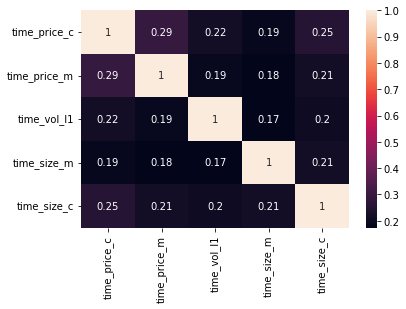

In [55]:
calculate_rank_correraltion(time_id_neighbors)

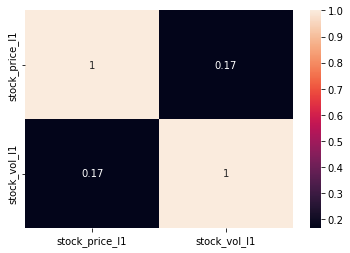

In [56]:
calculate_rank_correraltion(stock_id_neighbors)

#### Aggregate Features With Neighbors

In [57]:
# features with large changes over time are converted to relative ranks within time-id
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

In [58]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }
    
    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neigbor_sizes = [3, 5, 10, 20, 40]
    time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf: Optional[pd.DataFrame] = None

    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            return ndf

    # neighbor stock_id
    for feature_col in feature_cols_stock.keys():
        try:
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            if not stock_id_neighbors:
                continue

            for nn in stock_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes:
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
    ndf = None

    print(df2.shape)

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col == 'real_price':
                continue
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            if 'volatility' in feature_col:
                time_id_ns = time_id_neigbor_sizes_vol
            else:
                time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')

    # features further derived from nearest neighbor features
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"

                df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
                df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
                df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]

            for sz in time_id_neigbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"

                df2[f'vol_rankmin_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amin"]
                df2[f'vol_rankmax_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amax"]

        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        for c in price_cols:
            del df2[c]

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')

    return df2

In [59]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')

gc.collect()

(428935, 220)
(428935, 280)


/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
/tmp/ipykernel_3888766/1622911503.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

[make nearest neighbor feature]  23.847sec
(428935, 582)


0

### Misc Features

In [60]:
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')

In [61]:
# Rolling average of RV for similar trading volume
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    roll_target = 'book.log_return1.realized_volatility'

    for window_size in [3, 10]:
        df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
            df2.groupby('stock_id')[roll_target].rolling(window_size, center=True, min_periods=1) \
                                                .mean() \
                                                .reset_index() \
                                                .sort_values(by=['level_1'])[roll_target].values
except Exception:
    print_trace('mean RV')

/tmp/ipykernel_3888766/2475865050.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
/tmp/ipykernel_3888766/2475865050.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \


In [62]:
# stock-id embedding (helps little)
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot('time_id', 'stock_id', 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

/tmp/ipykernel_3888766/342520599.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
/tmp/ipykernel_3888766/342520599.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
/tmp/ipykernel_3888766/342520599.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

In [63]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

0

## Reverse Engineering time-id Order & Make CV Split

In [64]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet'))}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])
    
    return df_ordered[['time_id']]

In [1]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES:
            timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
        else:
            timeid_order = reconstruct_time_id_order()

    with timer('make folds'):
        timeid_order['time_id_order'] = np.arange(len(timeid_order))
        df_train['time_id_order'] = df_train['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df_train = df_train.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)

        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df_train['time_id_order']

        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    del df_train['time_id_order']
elif CV_SPLIT == 'group':
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df_train, None, groups=df_train['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError()
print(timeid_order)
# df_train.reset_index(drop=True, inplace=True)
# df_test.reset_index(drop=True, inplace=True)

NameError: name 'CV_SPLIT' is not defined

## LightGBM Training

In [66]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()

(428932, 584)


/home/steven/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.351803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.439827 seconds.
You can set `force_col_wise=true` to remove the overhead.


/home/steven/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	cv_agg's l2: 7.38841e-07 + 1.60798e-07	cv_agg's RMSPE: 0.38014 + 0.00986678
[40]	cv_agg's l2: 4.52997e-07 + 8.39884e-08	cv_agg's RMSPE: 0.298575 + 0.00421469
[60]	cv_agg's l2: 3.23867e-07 + 5.08634e-08	cv_agg's RMSPE: 0.253165 + 0.00590573
[80]	cv_agg's l2: 2.64498e-07 + 3.70575e-08	cv_agg's RMSPE: 0.229228 + 0.00877693
[100]	cv_agg's l2: 2.36538e-07 + 3.15655e-08	cv_agg's RMSPE: 0.217003 + 0.0104855
[120]	cv_agg's l2: 2.22859e-07 + 2.93145e-08	cv_agg's RMSPE: 0.21073 + 0.0113045
[140]	cv_agg's l2: 2.15812e-07 + 2.83972e-08	cv_agg's RMSPE: 0.207413 + 0.0116591
[160]	cv_agg's l2: 2.11899e-07 + 2.79571e-08	cv_agg's RMSPE: 0.205535 + 0.0117838
[180]	cv_agg's l2: 2.09614e-07 + 2.7764e-08	cv_agg's RMSPE: 0.204428 + 0.0118019
[200]	cv_agg's l2: 2.08055e-07 + 2.76584e-08	cv_agg's RMSPE: 0.203657 + 0.0117621
[220]	cv_agg's l2: 2.06944e-07 + 2.75676e-08	cv_agg's RMSPE: 0.20311 + 0.0117137
[240]	cv_agg's l2: 2.06171e-07 + 2.75507e-08	cv_agg's RMSPE: 0.202722 + 0.011675
[260]	cv_agg's l2: 2.

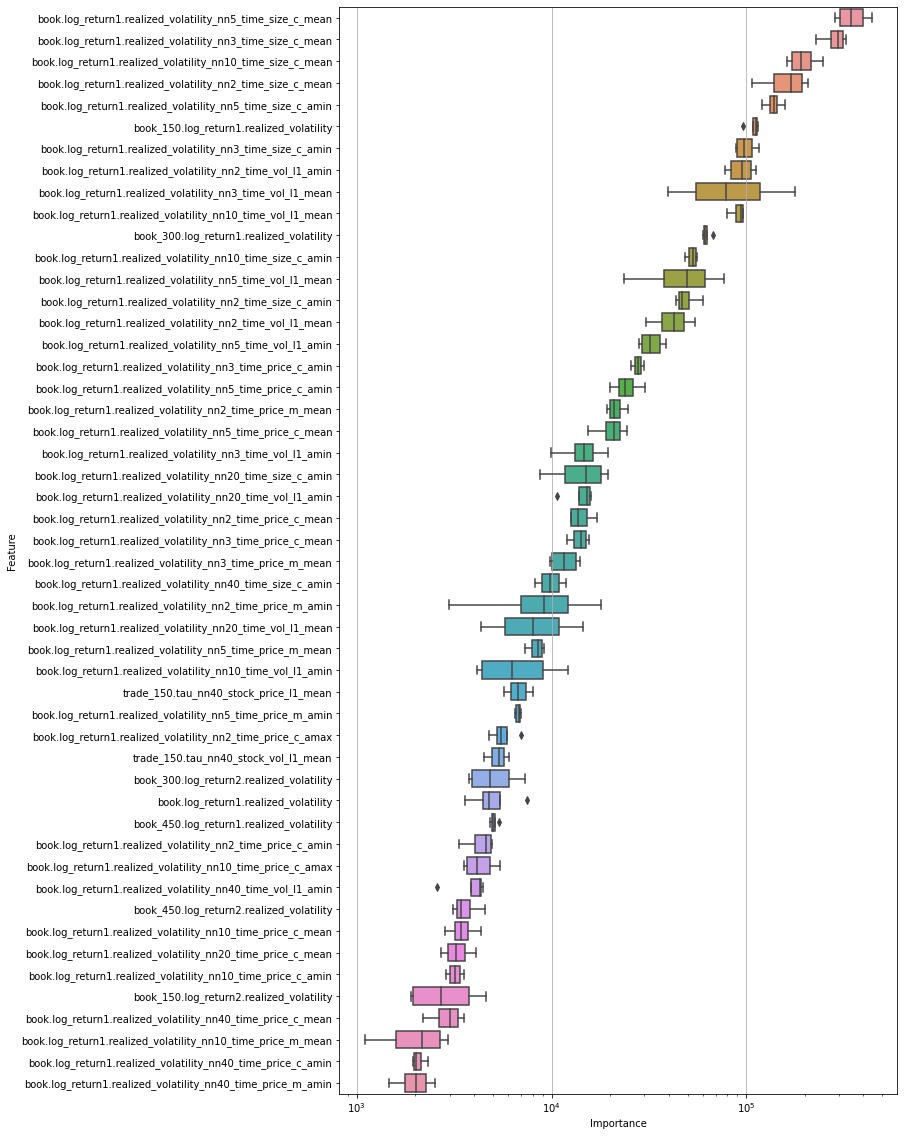

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.813982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.810432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.805092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.813741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.843208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[retraining] 566.163sec


35857

In [67]:
lr = GBDT_LR
if SHORTCUT_GBDT_IN_1ST_STAGE and IS_1ST_STAGE:
    # to save GPU quota
    lr = 0.3

params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')

gc.collect()

print(X.shape)

if PREDICT_GBDT:
    ds = lgb.Dataset(X, y, weight=1/np.power(y, 2))

    with timer('lgb.cv'):
        ret = lgb.cv(params, ds, num_boost_round=8000, folds=folds, #cv,
                     feval=feval_RMSPE, stratified=False, 
                     return_cvbooster=True, verbose_eval=20,
                     early_stopping_rounds=int(40*0.1/lr))

        print(f"# overall RMSPE: {ret['RMSPE-mean'][-1]}")

    best_iteration = len(ret['RMSPE-mean'])
    for i in range(len(folds)):
        y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
        y_true = y.iloc[folds[i][1]]
        print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
        
        if i == len(folds) - 1:
            np.save('pred_gbdt.npy', y_pred)

    plot_importance(ret['cvbooster'], figsize=(10, 20))

    boosters = []
    with timer('retraining'):
        for i in range(GBDT_NUM_MODELS):
            params['seed'] = i
            boosters.append(lgb.train(params, ds, num_boost_round=int(1.1*best_iteration)))

    booster = EnsembleModel(boosters)
    del ret
    del ds

gc.collect()

## NN Training

In [68]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
]


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def RMSPELoss_Tabnet(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module):
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs


def predict_tabnet(X: pd.DataFrame,
                   model: Union[List[TabNetRegressor], TabNetRegressor],
                   scaler: StandardScaler,
                   ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    X_processed = np.concatenate([X_cat, X_num], axis=1)

    predicted = []
    for m in model:
        predicted.append(m.predict(X_processed))

    if ensemble_method == 'median':
        pred = np.nanmedian(np.array(predicted), axis=0)
    else:
        pred = np.array(predicted).mean(axis=0)

    return pred


def train_tabnet(X: pd.DataFrame,
                 y: pd.DataFrame,
                 folds: List[Tuple],
                 batch_size: int = 1024,
                 lr: float = 1e-3,
                 model_path: str = 'fold_{}.pth',
                 scaler_type: str = 'standard',
                 output_dir: str = 'artifacts',
                 epochs: int = 250,
                 seed: int = 42,
                 n_pca: int = -1,
                 na_cols: bool = True,
                 patience: int = 10,
                 factor: float = 0.5,
                 gamma: float = 2.0,
                 lambda_sparse: float = 8.0,
                 n_steps: int = 2,
                 scheduler_type: str = 'cosine',
                 n_a: int = 16):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        y_tr = y_tr.reshape(-1,1)
        y_va = y_va.reshape(-1,1)
        X_tr = np.concatenate([X_tr_cat, X_tr], axis=1)
        X_va = np.concatenate([X_va_cat, X_va], axis=1)

        cat_idxs = [0]
        cat_dims = [128]

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-7, 'patience': patience, 'factor': factor, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=1,
            n_d=n_a,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': lr},
            mask_type="entmax",
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            seed=seed,
            verbose=10
            #device_name=device,
            #clip_value=1.5
        )

        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], max_epochs=epochs, patience=50, batch_size=1024*20,
                  virtual_batch_size=batch_size, num_workers=4, drop_last=False, eval_metric=[RMSPE], loss_fn=RMSPELoss_Tabnet)

        path = os.path.join(output_dir, model_path.format(cv_idx))
        model.save_model(path)

        predicted = model.predict(X_va)

        rmspe = rmspe_metric(y_va, predicted)
        best_losses.append(rmspe)
        best_predictions.append(predicted)

    return best_losses, best_predictions, scaler, model


def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

del df, df_train
gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]


if PREDICT_MLP:
    model_paths = []
    scores = []
    
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(NN_NUM_MODELS):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            scores.append(nn_losses[0])
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
            np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    mlp_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(mlp_model)} models will be used.')
if PREDICT_CNN:
    model_paths = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(NN_NUM_MODELS):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                               batch_size=1280,
                                               model_type='cnn',
                                               emb_dim=30,
                                               epochs=epochs, #epochs,
                                               cnn_channel1=128,
                                               cnn_channel2=3*128,
                                               cnn_channel3=3*128,
                                               lr=0.00038, #0.0011,
                                               max_lr=0.0013,
                                               weight_decay=6.5e-6,
                                               optimizer_type='adam',
                                               scheduler_type='reduce',
                                               model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                               seed=i,
                                               cnn_dropout=0.0,
                                               cnn_weight_norm=True,
                                               cnn_leaky_relu=False,
                                               patience=8,
                                               factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
            scores.append(nn_losses[0])
            np.save(f'pred_cnn_seed{i}.npy', nn_preds[0])
            
    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    cnn_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(cnn_model)} models will be used.')
    
if PREDICT_TABNET:
    tab_model = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 10
        valid_th = 1000
    else:
        print('train full')
        epochs = 250
        valid_th = NN_VALID_TH

    for i in range(TABNET_NUM_MODELS):
        nn_losses, nn_preds, scaler, model = train_tabnet(X, y,  
                                                          [folds[-1]], 
                                                          batch_size=1280,
                                                          epochs=epochs, #epochs,
                                                          lr=0.04,
                                                          patience=50,
                                                          factor=0.5,
                                                          gamma=1.6,
                                                          lambda_sparse=3.55e-6,
                                                          seed=i,
                                                          n_a=36)
        if nn_losses[0] < valid_th:
            tab_model.append(model)
            scores.append(nn_losses[0])
            np.save(f'pred_tab_seed{i}.npy', nn_preds[0])
            model.save_model(f'artifacts/tabnet_fold_0_seed{i}')
            
    tab_model = get_top_n_models(tab_model, scores, TAB_MODEL_TOP_N)
    print(f'total {len(tab_model)} models will be used.')

cuda
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.92it/s]


epoch 0, train loss: 22.372, valid rmspe: 4.753
new best:4.752574920654297


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.35it/s]


epoch 1, train loss: 5.762, valid rmspe: 1.034
new best:1.0342416763305664


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.46it/s]


epoch 2, train loss: 6.080, valid rmspe: 1.765


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.94it/s]


epoch 3, train loss: 1.859, valid rmspe: 0.263
new best:0.2628456652164459


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.81it/s]


epoch 4, train loss: 0.884, valid rmspe: 0.969


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.28it/s]


epoch 5, train loss: 0.676, valid rmspe: 0.351


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.74it/s]


epoch 6, train loss: 0.484, valid rmspe: 0.326


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.27it/s]


epoch 7, train loss: 0.439, valid rmspe: 0.431


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.10it/s]


epoch 8, train loss: 0.412, valid rmspe: 0.229
new best:0.2286132276058197


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.41it/s]


epoch 9, train loss: 0.437, valid rmspe: 0.334


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.66it/s]


epoch 10, train loss: 0.471, valid rmspe: 0.377


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.97it/s]


epoch 11, train loss: 0.468, valid rmspe: 0.375


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.04it/s]


epoch 12, train loss: 0.447, valid rmspe: 0.477


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.82it/s]


epoch 13, train loss: 0.434, valid rmspe: 0.224
new best:0.22447380423545837


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.46it/s]


epoch 14, train loss: 0.372, valid rmspe: 0.447


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.61it/s]


epoch 15, train loss: 0.351, valid rmspe: 0.215
new best:0.21536467969417572


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.38it/s]


epoch 16, train loss: 0.283, valid rmspe: 0.200
new best:0.19959403574466705


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.97it/s]


epoch 17, train loss: 0.299, valid rmspe: 0.204


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.73it/s]


epoch 18, train loss: 0.270, valid rmspe: 0.192
new best:0.19241510331630707


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.11it/s]


epoch 19, train loss: 0.263, valid rmspe: 0.213


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.06it/s]


epoch 20, train loss: 0.246, valid rmspe: 0.216


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.26it/s]


epoch 21, train loss: 0.249, valid rmspe: 0.212


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.62it/s]


epoch 22, train loss: 0.236, valid rmspe: 0.200


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 158.83it/s]


epoch 23, train loss: 0.228, valid rmspe: 0.254


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.37it/s]


epoch 24, train loss: 0.216, valid rmspe: 0.194


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 142.95it/s]


epoch 25, train loss: 0.213, valid rmspe: 0.188
new best:0.18794851005077362


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.51it/s]


epoch 26, train loss: 0.208, valid rmspe: 0.185
new best:0.18493786454200745


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.73it/s]


epoch 27, train loss: 0.202, valid rmspe: 0.183
new best:0.1826704740524292


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.37it/s]


epoch 28, train loss: 0.200, valid rmspe: 0.183


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.84it/s]


epoch 29, train loss: 0.198, valid rmspe: 0.183
model of seed 0 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.45it/s]


epoch 0, train loss: 25.902, valid rmspe: 8.347
new best:8.346624374389648


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.53it/s]


epoch 1, train loss: 6.927, valid rmspe: 3.117
new best:3.117349624633789


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.80it/s]


epoch 2, train loss: 5.017, valid rmspe: 1.863
new best:1.8629391193389893


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.14it/s]


epoch 3, train loss: 1.479, valid rmspe: 0.264
new best:0.2638780474662781


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.86it/s]


epoch 4, train loss: 0.691, valid rmspe: 0.404


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.64it/s]


epoch 5, train loss: 0.706, valid rmspe: 0.641


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.70it/s]


epoch 6, train loss: 0.533, valid rmspe: 0.839


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.14it/s]


epoch 7, train loss: 0.470, valid rmspe: 0.615


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.77it/s]


epoch 8, train loss: 0.414, valid rmspe: 0.330


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.61it/s]


epoch 9, train loss: 0.379, valid rmspe: 0.375


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.40it/s]


epoch 10, train loss: 0.356, valid rmspe: 0.247
new best:0.24733875691890717


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.49it/s]


epoch 11, train loss: 0.379, valid rmspe: 0.247
new best:0.24679556488990784


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.72it/s]


epoch 12, train loss: 0.353, valid rmspe: 0.358


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.74it/s]


epoch 13, train loss: 0.349, valid rmspe: 0.213
new best:0.21286676824092865


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.66it/s]


epoch 14, train loss: 0.312, valid rmspe: 0.210
new best:0.20974263548851013


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.28it/s]


epoch 15, train loss: 0.311, valid rmspe: 0.308


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.31it/s]


epoch 16, train loss: 0.384, valid rmspe: 0.397


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.75it/s]


epoch 17, train loss: 0.297, valid rmspe: 0.194
new best:0.1935134381055832


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.01it/s]


epoch 18, train loss: 0.286, valid rmspe: 0.254


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.51it/s]


epoch 19, train loss: 0.266, valid rmspe: 0.243


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.62it/s]


epoch 20, train loss: 0.249, valid rmspe: 0.193
new best:0.19333338737487793


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.68it/s]


epoch 21, train loss: 0.241, valid rmspe: 0.266


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.96it/s]


epoch 22, train loss: 0.234, valid rmspe: 0.227


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 156.68it/s]


epoch 23, train loss: 0.230, valid rmspe: 0.312


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.19it/s]


epoch 24, train loss: 0.215, valid rmspe: 0.183
new best:0.18300898373126984


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.20it/s]


epoch 25, train loss: 0.206, valid rmspe: 0.202


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.39it/s]


epoch 26, train loss: 0.205, valid rmspe: 0.183
new best:0.1825355887413025


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.53it/s]


epoch 27, train loss: 0.201, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.08it/s]


epoch 28, train loss: 0.199, valid rmspe: 0.182
new best:0.18239125609397888


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.42it/s]


epoch 29, train loss: 0.198, valid rmspe: 0.183
model of seed 1 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.08it/s]


epoch 0, train loss: 22.957, valid rmspe: 4.437
new best:4.437321662902832


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.38it/s]


epoch 1, train loss: 6.313, valid rmspe: 5.187


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.50it/s]


epoch 2, train loss: 5.243, valid rmspe: 4.669


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.05it/s]


epoch 3, train loss: 2.395, valid rmspe: 1.107
new best:1.1068626642227173


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.42it/s]


epoch 4, train loss: 0.930, valid rmspe: 0.728
new best:0.7275764346122742


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.56it/s]


epoch 5, train loss: 0.724, valid rmspe: 0.807


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.89it/s]


epoch 6, train loss: 0.635, valid rmspe: 0.269
new best:0.2685512602329254


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.72it/s]


epoch 7, train loss: 0.489, valid rmspe: 0.312


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.32it/s]


epoch 8, train loss: 0.548, valid rmspe: 0.420


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.55it/s]


epoch 9, train loss: 0.491, valid rmspe: 0.595


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.70it/s]


epoch 10, train loss: 0.414, valid rmspe: 0.223
new best:0.22344279289245605


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.25it/s]


epoch 11, train loss: 0.418, valid rmspe: 0.282


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.43it/s]


epoch 12, train loss: 0.407, valid rmspe: 0.213
new best:0.21321535110473633


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.08it/s]


epoch 13, train loss: 0.415, valid rmspe: 0.476


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.03it/s]


epoch 14, train loss: 0.384, valid rmspe: 0.298


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.37it/s]


epoch 15, train loss: 0.349, valid rmspe: 0.422


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.43it/s]


epoch 16, train loss: 0.321, valid rmspe: 0.233


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.69it/s]


epoch 17, train loss: 0.301, valid rmspe: 0.196
new best:0.19635164737701416


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.85it/s]


epoch 18, train loss: 0.297, valid rmspe: 0.335


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.87it/s]


epoch 19, train loss: 0.276, valid rmspe: 0.197


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.74it/s]


epoch 20, train loss: 0.277, valid rmspe: 0.215


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.99it/s]


epoch 21, train loss: 0.255, valid rmspe: 0.202


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.04it/s]


epoch 22, train loss: 0.244, valid rmspe: 0.201


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.90it/s]


epoch 23, train loss: 0.226, valid rmspe: 0.193
new best:0.19260866940021515


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.45it/s]


epoch 24, train loss: 0.221, valid rmspe: 0.226


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.41it/s]


epoch 25, train loss: 0.210, valid rmspe: 0.199


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 141.82it/s]


epoch 26, train loss: 0.209, valid rmspe: 0.191
new best:0.19114981591701508


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.69it/s]


epoch 27, train loss: 0.202, valid rmspe: 0.185
new best:0.18460118770599365


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.11it/s]


epoch 28, train loss: 0.200, valid rmspe: 0.186


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.61it/s]


epoch 29, train loss: 0.198, valid rmspe: 0.183
new best:0.1826966106891632
model of seed 2 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.98it/s]


epoch 0, train loss: 25.893, valid rmspe: 4.976
new best:4.975886821746826


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.71it/s]


epoch 1, train loss: 5.664, valid rmspe: 4.573
new best:4.5726189613342285


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.50it/s]


epoch 2, train loss: 4.588, valid rmspe: 2.356
new best:2.35612154006958


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.67it/s]


epoch 3, train loss: 2.007, valid rmspe: 1.519
new best:1.5186713933944702


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.19it/s]


epoch 4, train loss: 0.857, valid rmspe: 0.376
new best:0.37629228830337524


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.03it/s]


epoch 5, train loss: 0.724, valid rmspe: 0.413


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.24it/s]


epoch 6, train loss: 0.632, valid rmspe: 0.384


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.63it/s]


epoch 7, train loss: 0.632, valid rmspe: 0.259
new best:0.25900837779045105


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.80it/s]


epoch 8, train loss: 0.562, valid rmspe: 0.224
new best:0.22418265044689178


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.80it/s]


epoch 9, train loss: 0.574, valid rmspe: 0.400


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.25it/s]


epoch 10, train loss: 0.548, valid rmspe: 0.268


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.49it/s]


epoch 11, train loss: 0.472, valid rmspe: 0.622


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.22it/s]


epoch 12, train loss: 0.471, valid rmspe: 0.281


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.79it/s]


epoch 13, train loss: 0.414, valid rmspe: 0.298


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.20it/s]


epoch 14, train loss: 0.369, valid rmspe: 0.326


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.94it/s]


epoch 15, train loss: 0.385, valid rmspe: 0.271


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 142.47it/s]


epoch 16, train loss: 0.352, valid rmspe: 0.523


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.98it/s]


epoch 17, train loss: 0.336, valid rmspe: 0.202
new best:0.20245978236198425


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.24it/s]


epoch 18, train loss: 0.311, valid rmspe: 0.265


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.13it/s]


epoch 19, train loss: 0.300, valid rmspe: 0.204


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.99it/s]


epoch 20, train loss: 0.272, valid rmspe: 0.232


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.41it/s]


epoch 21, train loss: 0.261, valid rmspe: 0.226


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.66it/s]


epoch 22, train loss: 0.252, valid rmspe: 0.283


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.62it/s]


epoch 23, train loss: 0.232, valid rmspe: 0.189
new best:0.18899482488632202


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.97it/s]


epoch 24, train loss: 0.228, valid rmspe: 0.223


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.95it/s]


epoch 25, train loss: 0.217, valid rmspe: 0.192


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.96it/s]


epoch 26, train loss: 0.215, valid rmspe: 0.184
new best:0.18358808755874634


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.55it/s]


epoch 27, train loss: 0.207, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.61it/s]


epoch 28, train loss: 0.202, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.85it/s]


epoch 29, train loss: 0.201, valid rmspe: 0.184
model of seed 3 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.57it/s]


epoch 0, train loss: 24.434, valid rmspe: 4.010
new best:4.009545803070068


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.56it/s]


epoch 1, train loss: 8.192, valid rmspe: 5.687


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.89it/s]


epoch 2, train loss: 4.852, valid rmspe: 1.279
new best:1.278573751449585


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.89it/s]


epoch 3, train loss: 1.503, valid rmspe: 0.264
new best:0.264295369386673


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.09it/s]


epoch 4, train loss: 0.730, valid rmspe: 0.254
new best:0.2537139058113098


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.93it/s]


epoch 5, train loss: 0.679, valid rmspe: 0.801


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.88it/s]


epoch 6, train loss: 0.639, valid rmspe: 0.669


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.40it/s]


epoch 7, train loss: 0.580, valid rmspe: 0.756


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.10it/s]


epoch 8, train loss: 0.577, valid rmspe: 0.566


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.34it/s]


epoch 9, train loss: 0.549, valid rmspe: 0.388


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.86it/s]


epoch 10, train loss: 0.495, valid rmspe: 0.324


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.87it/s]


epoch 11, train loss: 0.387, valid rmspe: 0.332


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.05it/s]


epoch 12, train loss: 0.437, valid rmspe: 0.364


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.26it/s]


epoch 13, train loss: 0.399, valid rmspe: 0.228
new best:0.22765451669692993


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.16it/s]


epoch 14, train loss: 0.345, valid rmspe: 0.241


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.78it/s]


epoch 15, train loss: 0.338, valid rmspe: 0.364


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.14it/s]


epoch 16, train loss: 0.301, valid rmspe: 0.245


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.65it/s]


epoch 17, train loss: 0.283, valid rmspe: 0.307


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.54it/s]


epoch 18, train loss: 0.286, valid rmspe: 0.206
new best:0.20618575811386108


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.67it/s]


epoch 19, train loss: 0.262, valid rmspe: 0.184
new best:0.18415620923042297


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.43it/s]


epoch 20, train loss: 0.244, valid rmspe: 0.186


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.22it/s]


epoch 21, train loss: 0.242, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.54it/s]


epoch 22, train loss: 0.234, valid rmspe: 0.250


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.07it/s]


epoch 23, train loss: 0.226, valid rmspe: 0.185


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.74it/s]


epoch 24, train loss: 0.219, valid rmspe: 0.188


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.88it/s]


epoch 25, train loss: 0.206, valid rmspe: 0.188


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.74it/s]


epoch 26, train loss: 0.207, valid rmspe: 0.198


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.23it/s]


epoch 27, train loss: 0.201, valid rmspe: 0.187


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.26it/s]


epoch 28, train loss: 0.198, valid rmspe: 0.184
new best:0.18403522670269012


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.66it/s]


epoch 29, train loss: 0.198, valid rmspe: 0.183
new best:0.18262185156345367
model of seed 4 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.06it/s]


epoch 0, train loss: 27.567, valid rmspe: 5.724
new best:5.724095821380615


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.94it/s]


epoch 1, train loss: 6.468, valid rmspe: 7.909


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.60it/s]


epoch 2, train loss: 5.987, valid rmspe: 1.873
new best:1.8731366395950317


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.29it/s]


epoch 3, train loss: 2.408, valid rmspe: 1.145
new best:1.1449710130691528


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.50it/s]


epoch 4, train loss: 1.156, valid rmspe: 0.400
new best:0.40017247200012207


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.19it/s]


epoch 5, train loss: 0.777, valid rmspe: 0.566


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.05it/s]


epoch 6, train loss: 0.623, valid rmspe: 0.302
new best:0.3018873333930969


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.58it/s]


epoch 7, train loss: 0.498, valid rmspe: 0.467


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.90it/s]


epoch 8, train loss: 0.524, valid rmspe: 0.455


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.70it/s]


epoch 9, train loss: 0.448, valid rmspe: 0.639


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.22it/s]


epoch 10, train loss: 0.429, valid rmspe: 0.302
new best:0.30161017179489136


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.55it/s]


epoch 11, train loss: 0.380, valid rmspe: 0.652


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.33it/s]


epoch 12, train loss: 0.403, valid rmspe: 0.496


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.44it/s]


epoch 13, train loss: 0.362, valid rmspe: 0.228
new best:0.2278258055448532


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 156.15it/s]


epoch 14, train loss: 0.314, valid rmspe: 0.426


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.07it/s]


epoch 15, train loss: 0.308, valid rmspe: 0.282


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.08it/s]


epoch 16, train loss: 0.296, valid rmspe: 0.234


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.58it/s]


epoch 17, train loss: 0.276, valid rmspe: 0.205
new best:0.20462577044963837


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.84it/s]


epoch 18, train loss: 0.280, valid rmspe: 0.221


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.86it/s]


epoch 19, train loss: 0.264, valid rmspe: 0.203
new best:0.20276771485805511


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 141.64it/s]


epoch 20, train loss: 0.242, valid rmspe: 0.234


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 141.23it/s]


epoch 21, train loss: 0.231, valid rmspe: 0.186
new best:0.18634337186813354


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 139.27it/s]


epoch 22, train loss: 0.228, valid rmspe: 0.199


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.18it/s]


epoch 23, train loss: 0.216, valid rmspe: 0.204


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.57it/s]


epoch 24, train loss: 0.212, valid rmspe: 0.186


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.35it/s]


epoch 25, train loss: 0.218, valid rmspe: 0.186
new best:0.18572302162647247


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.18it/s]


epoch 26, train loss: 0.208, valid rmspe: 0.194


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 156.17it/s]


epoch 27, train loss: 0.201, valid rmspe: 0.183
new best:0.1830705851316452


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.39it/s]


epoch 28, train loss: 0.200, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.54it/s]


epoch 29, train loss: 0.199, valid rmspe: 0.183
new best:0.18277326226234436
model of seed 5 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 141.87it/s]


epoch 0, train loss: 24.179, valid rmspe: 2.533
new best:2.533374309539795


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.14it/s]


epoch 1, train loss: 6.312, valid rmspe: 8.727


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.26it/s]


epoch 2, train loss: 5.375, valid rmspe: 1.430
new best:1.4298818111419678


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.09it/s]


epoch 3, train loss: 1.786, valid rmspe: 0.315
new best:0.31544557213783264


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.32it/s]


epoch 4, train loss: 0.789, valid rmspe: 0.926


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.47it/s]


epoch 5, train loss: 0.771, valid rmspe: 0.317


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.37it/s]


epoch 6, train loss: 0.682, valid rmspe: 1.084


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.94it/s]


epoch 7, train loss: 0.466, valid rmspe: 0.355


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.24it/s]


epoch 8, train loss: 0.429, valid rmspe: 0.334


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.15it/s]


epoch 9, train loss: 0.452, valid rmspe: 0.396


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.41it/s]


epoch 10, train loss: 0.454, valid rmspe: 0.236
new best:0.23614445328712463


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.76it/s]


epoch 11, train loss: 0.389, valid rmspe: 0.508


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.99it/s]


epoch 12, train loss: 0.361, valid rmspe: 0.339


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.07it/s]


epoch 13, train loss: 0.368, valid rmspe: 0.556


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.06it/s]


epoch 14, train loss: 0.382, valid rmspe: 0.251


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.81it/s]


epoch 15, train loss: 0.323, valid rmspe: 0.211
new best:0.21069465577602386


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.97it/s]


epoch 16, train loss: 0.305, valid rmspe: 0.357


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.83it/s]


epoch 17, train loss: 0.272, valid rmspe: 0.309


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.05it/s]


epoch 18, train loss: 0.305, valid rmspe: 0.311


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.10it/s]


epoch 19, train loss: 0.264, valid rmspe: 0.258


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.46it/s]


epoch 20, train loss: 0.239, valid rmspe: 0.188
new best:0.18772175908088684


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.70it/s]


epoch 21, train loss: 0.239, valid rmspe: 0.183
new best:0.18331533670425415


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 156.49it/s]


epoch 22, train loss: 0.226, valid rmspe: 0.197


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 139.73it/s]


epoch 23, train loss: 0.226, valid rmspe: 0.189


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.43it/s]


epoch 24, train loss: 0.213, valid rmspe: 0.191


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.42it/s]


epoch 25, train loss: 0.210, valid rmspe: 0.182
new best:0.18239997327327728


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.54it/s]


epoch 26, train loss: 0.205, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.56it/s]


epoch 27, train loss: 0.201, valid rmspe: 0.182
new best:0.18187078833580017


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.77it/s]


epoch 28, train loss: 0.198, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.38it/s]


epoch 29, train loss: 0.198, valid rmspe: 0.183
model of seed 6 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.52it/s]


epoch 0, train loss: 23.697, valid rmspe: 3.496
new best:3.495781898498535


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.72it/s]


epoch 1, train loss: 5.203, valid rmspe: 3.512


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.85it/s]


epoch 2, train loss: 5.237, valid rmspe: 2.335
new best:2.3347554206848145


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.22it/s]


epoch 3, train loss: 2.288, valid rmspe: 1.223
new best:1.2227176427841187


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.32it/s]


epoch 4, train loss: 0.788, valid rmspe: 0.714
new best:0.7140625715255737


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.66it/s]


epoch 5, train loss: 0.574, valid rmspe: 0.391
new best:0.39139053225517273


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.47it/s]


epoch 6, train loss: 0.526, valid rmspe: 0.430


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.77it/s]


epoch 7, train loss: 0.547, valid rmspe: 0.424


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.61it/s]


epoch 8, train loss: 0.462, valid rmspe: 0.764


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.70it/s]


epoch 9, train loss: 0.554, valid rmspe: 0.336
new best:0.3361545205116272


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.39it/s]


epoch 10, train loss: 0.516, valid rmspe: 0.533


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.24it/s]


epoch 11, train loss: 0.465, valid rmspe: 0.470


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.00it/s]


epoch 12, train loss: 0.428, valid rmspe: 0.351


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.05it/s]


epoch 13, train loss: 0.335, valid rmspe: 0.381


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.87it/s]


epoch 14, train loss: 0.312, valid rmspe: 0.315
new best:0.3146698474884033


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.55it/s]


epoch 15, train loss: 0.315, valid rmspe: 0.213
new best:0.21320806443691254


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.05it/s]


epoch 16, train loss: 0.290, valid rmspe: 0.191
new best:0.19113920629024506


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.58it/s]


epoch 17, train loss: 0.301, valid rmspe: 0.290


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.28it/s]


epoch 18, train loss: 0.290, valid rmspe: 0.283


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.06it/s]


epoch 19, train loss: 0.260, valid rmspe: 0.198


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.19it/s]


epoch 20, train loss: 0.248, valid rmspe: 0.252


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.55it/s]


epoch 21, train loss: 0.233, valid rmspe: 0.192


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.87it/s]


epoch 22, train loss: 0.228, valid rmspe: 0.184
new best:0.18380025029182434


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 141.29it/s]


epoch 23, train loss: 0.225, valid rmspe: 0.192


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.82it/s]


epoch 24, train loss: 0.208, valid rmspe: 0.183
new best:0.18336494266986847


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.32it/s]


epoch 25, train loss: 0.210, valid rmspe: 0.183
new best:0.18260619044303894


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.17it/s]


epoch 26, train loss: 0.203, valid rmspe: 0.183


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.45it/s]


epoch 27, train loss: 0.201, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.92it/s]


epoch 28, train loss: 0.198, valid rmspe: 0.182
new best:0.18225085735321045


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.40it/s]


epoch 29, train loss: 0.197, valid rmspe: 0.182
new best:0.1822158396244049
model of seed 7 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 142.58it/s]


epoch 0, train loss: 24.316, valid rmspe: 6.537
new best:6.536843776702881


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.95it/s]


epoch 1, train loss: 6.763, valid rmspe: 4.523
new best:4.523130416870117


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.31it/s]


epoch 2, train loss: 5.890, valid rmspe: 3.080
new best:3.0799803733825684


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.81it/s]


epoch 3, train loss: 2.238, valid rmspe: 0.589
new best:0.5893601179122925


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.39it/s]


epoch 4, train loss: 1.029, valid rmspe: 0.391
new best:0.39055144786834717


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.54it/s]


epoch 5, train loss: 0.674, valid rmspe: 0.422


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.60it/s]


epoch 6, train loss: 0.534, valid rmspe: 0.507


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.67it/s]


epoch 7, train loss: 0.627, valid rmspe: 0.276
new best:0.2758009433746338


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.12it/s]


epoch 8, train loss: 0.532, valid rmspe: 0.413


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.56it/s]


epoch 9, train loss: 0.380, valid rmspe: 0.216
new best:0.21557816863059998


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.01it/s]


epoch 10, train loss: 0.456, valid rmspe: 0.276


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.74it/s]


epoch 11, train loss: 0.372, valid rmspe: 0.682


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.33it/s]


epoch 12, train loss: 0.446, valid rmspe: 0.264


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.00it/s]


epoch 13, train loss: 0.380, valid rmspe: 0.188
new best:0.18775807321071625


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.93it/s]


epoch 14, train loss: 0.323, valid rmspe: 0.407


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.36it/s]


epoch 15, train loss: 0.354, valid rmspe: 0.394


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 142.63it/s]


epoch 16, train loss: 0.335, valid rmspe: 0.204


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.09it/s]


epoch 17, train loss: 0.281, valid rmspe: 0.192


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.70it/s]


epoch 18, train loss: 0.286, valid rmspe: 0.325


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.36it/s]


epoch 19, train loss: 0.265, valid rmspe: 0.208


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 156.02it/s]


epoch 20, train loss: 0.252, valid rmspe: 0.190


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.81it/s]


epoch 21, train loss: 0.246, valid rmspe: 0.199


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.40it/s]


epoch 22, train loss: 0.226, valid rmspe: 0.186
new best:0.18640480935573578


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.65it/s]


epoch 23, train loss: 0.221, valid rmspe: 0.185
new best:0.18503782153129578


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.41it/s]


epoch 24, train loss: 0.216, valid rmspe: 0.185
new best:0.18489444255828857


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.38it/s]


epoch 25, train loss: 0.211, valid rmspe: 0.216


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.92it/s]


epoch 26, train loss: 0.207, valid rmspe: 0.183
new best:0.18291930854320526


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 153.31it/s]


epoch 27, train loss: 0.200, valid rmspe: 0.184


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.67it/s]


epoch 28, train loss: 0.199, valid rmspe: 0.182
new best:0.18224793672561646


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.95it/s]


epoch 29, train loss: 0.197, valid rmspe: 0.182
model of seed 8 added.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.34it/s]


epoch 0, train loss: 24.461, valid rmspe: 5.369
new best:5.369041442871094


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.56it/s]


epoch 1, train loss: 6.939, valid rmspe: 7.630


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.64it/s]


epoch 2, train loss: 5.036, valid rmspe: 4.001
new best:4.001275539398193


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 150.84it/s]


epoch 3, train loss: 1.536, valid rmspe: 0.589
new best:0.5894321799278259


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 156.78it/s]


epoch 4, train loss: 0.843, valid rmspe: 0.857


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.22it/s]


epoch 5, train loss: 0.548, valid rmspe: 0.661


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.83it/s]


epoch 6, train loss: 0.654, valid rmspe: 0.562
new best:0.5623127222061157


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 134.07it/s]


epoch 7, train loss: 0.516, valid rmspe: 0.578


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.25it/s]


epoch 8, train loss: 0.589, valid rmspe: 0.247
new best:0.2467920184135437


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.39it/s]


epoch 9, train loss: 0.573, valid rmspe: 0.432


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 157.79it/s]


epoch 10, train loss: 0.425, valid rmspe: 0.451


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.63it/s]


epoch 11, train loss: 0.440, valid rmspe: 0.286


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.38it/s]


epoch 12, train loss: 0.455, valid rmspe: 0.226
new best:0.22616133093833923


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.89it/s]


epoch 13, train loss: 0.414, valid rmspe: 0.373


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.88it/s]


epoch 14, train loss: 0.383, valid rmspe: 0.208
new best:0.2077070027589798


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.64it/s]


epoch 15, train loss: 0.363, valid rmspe: 0.220


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 149.46it/s]


epoch 16, train loss: 0.337, valid rmspe: 0.494


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.05it/s]


epoch 17, train loss: 0.337, valid rmspe: 0.324


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 146.53it/s]


epoch 18, train loss: 0.293, valid rmspe: 0.303


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.54it/s]


epoch 19, train loss: 0.296, valid rmspe: 0.199
new best:0.1987466961145401


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 154.63it/s]


epoch 20, train loss: 0.249, valid rmspe: 0.204


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 151.74it/s]


epoch 21, train loss: 0.246, valid rmspe: 0.211


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 155.18it/s]


epoch 22, train loss: 0.231, valid rmspe: 0.313


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.95it/s]


epoch 23, train loss: 0.226, valid rmspe: 0.245


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 144.34it/s]


epoch 24, train loss: 0.217, valid rmspe: 0.191
new best:0.19092558324337006


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 145.70it/s]


epoch 25, train loss: 0.214, valid rmspe: 0.184
new best:0.18419314920902252


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 143.96it/s]


epoch 26, train loss: 0.206, valid rmspe: 0.183
new best:0.18282920122146606


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 152.58it/s]


epoch 27, train loss: 0.202, valid rmspe: 0.185


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 148.96it/s]


epoch 28, train loss: 0.200, valid rmspe: 0.183
new best:0.18282321095466614


Evaluating: 100%|███████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 147.76it/s]


epoch 29, train loss: 0.199, valid rmspe: 0.183
model of seed 9 added.
scores(sorted): [0.18187079, 0.18221584, 0.18224794, 0.18239126, 0.18262185, 0.18267047, 0.18269661, 0.18277326, 0.18282321, 0.18358809]
total 3 models will be used.
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.04it/s]


epoch 0, train loss: 32.011, valid rmspe: 5.435
new best:5.434852600097656


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.53it/s]


epoch 1, train loss: 5.691, valid rmspe: 6.056


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.64it/s]


epoch 2, train loss: 5.749, valid rmspe: 2.317
new best:2.317324161529541


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.09it/s]


epoch 3, train loss: 6.710, valid rmspe: 4.295


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.52it/s]


epoch 4, train loss: 6.610, valid rmspe: 5.217


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.48it/s]


epoch 5, train loss: 5.155, valid rmspe: 3.513


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.24it/s]


epoch 6, train loss: 2.866, valid rmspe: 2.977


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.87it/s]


epoch 7, train loss: 2.384, valid rmspe: 3.866


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.10it/s]


epoch 8, train loss: 1.733, valid rmspe: 0.916
new best:0.9155956506729126


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.09it/s]


epoch 9, train loss: 1.683, valid rmspe: 2.217


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.01it/s]


epoch 10, train loss: 1.027, valid rmspe: 0.690
new best:0.690470814704895


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.22it/s]


epoch 11, train loss: 1.591, valid rmspe: 0.331
new best:0.330839067697525


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.01it/s]


epoch 12, train loss: 1.372, valid rmspe: 0.657


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.61it/s]


epoch 13, train loss: 0.807, valid rmspe: 0.255
new best:0.25483500957489014


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.11it/s]


epoch 14, train loss: 0.751, valid rmspe: 0.482


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 53.88it/s]


epoch 15, train loss: 0.626, valid rmspe: 0.420


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.01it/s]


epoch 16, train loss: 0.543, valid rmspe: 0.876


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.21it/s]


epoch 17, train loss: 0.547, valid rmspe: 0.374


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.90it/s]


epoch 18, train loss: 0.514, valid rmspe: 0.439


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 53.59it/s]


epoch 19, train loss: 0.444, valid rmspe: 0.764


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.98it/s]


epoch 20, train loss: 0.703, valid rmspe: 0.244
new best:0.24439100921154022


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.93it/s]


epoch 21, train loss: 0.455, valid rmspe: 0.241
new best:0.24074505269527435


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.46it/s]


epoch 22, train loss: 0.471, valid rmspe: 0.233
new best:0.23265387117862701


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.95it/s]


epoch 23, train loss: 0.434, valid rmspe: 0.708


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.75it/s]


epoch 24, train loss: 0.488, valid rmspe: 0.267


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.84it/s]


epoch 25, train loss: 0.407, valid rmspe: 0.322


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.71it/s]


epoch 26, train loss: 0.422, valid rmspe: 0.567


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.68it/s]


epoch 27, train loss: 0.400, valid rmspe: 0.193
new best:0.19321514666080475


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.27it/s]


epoch 28, train loss: 0.512, valid rmspe: 0.296


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.90it/s]


epoch 29, train loss: 0.403, valid rmspe: 0.519


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.10it/s]


epoch 30, train loss: 0.515, valid rmspe: 0.197


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.76it/s]


epoch 31, train loss: 0.331, valid rmspe: 0.336


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.19it/s]


epoch 32, train loss: 0.324, valid rmspe: 0.267


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.64it/s]


epoch 33, train loss: 0.334, valid rmspe: 0.324


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.06it/s]


epoch 34, train loss: 0.311, valid rmspe: 0.199


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 53.64it/s]


epoch 35, train loss: 0.297, valid rmspe: 0.220


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.76it/s]


epoch 36, train loss: 0.236, valid rmspe: 0.184
new best:0.18428613245487213


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.68it/s]


epoch 37, train loss: 0.220, valid rmspe: 0.191


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.56it/s]


epoch 38, train loss: 0.222, valid rmspe: 0.211


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.75it/s]


epoch 39, train loss: 0.218, valid rmspe: 0.207


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.21it/s]


epoch 40, train loss: 0.215, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.48it/s]


epoch 41, train loss: 0.208, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.00it/s]


epoch 42, train loss: 0.212, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.63it/s]


epoch 43, train loss: 0.205, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.59it/s]


epoch 44, train loss: 0.210, valid rmspe: 0.193


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.65it/s]


epoch 45, train loss: 0.209, valid rmspe: 0.197
Epoch 00046: reducing learning rate of group 0 to 1.1400e-04.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.04it/s]


epoch 46, train loss: 0.197, valid rmspe: 0.183
new best:0.1831127554178238


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.43it/s]


epoch 47, train loss: 0.197, valid rmspe: 0.182
new best:0.18160590529441833


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.98it/s]


epoch 48, train loss: 0.196, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.74it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.187
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.08it/s]


epoch 0, train loss: 36.659, valid rmspe: 9.809
new best:9.808764457702637


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.22it/s]


epoch 1, train loss: 7.696, valid rmspe: 7.764
new best:7.76447868347168


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.37it/s]


epoch 2, train loss: 6.037, valid rmspe: 2.815
new best:2.815337896347046


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.87it/s]


epoch 3, train loss: 4.338, valid rmspe: 3.163


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.91it/s]


epoch 4, train loss: 2.592, valid rmspe: 1.189
new best:1.1893701553344727


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.14it/s]


epoch 5, train loss: 3.535, valid rmspe: 4.875


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 53.69it/s]


epoch 6, train loss: 2.568, valid rmspe: 1.390


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.22it/s]


epoch 7, train loss: 2.140, valid rmspe: 1.654


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.56it/s]


epoch 8, train loss: 1.291, valid rmspe: 1.166
new best:1.1661964654922485


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.12it/s]


epoch 9, train loss: 0.645, valid rmspe: 0.389
new best:0.38901281356811523


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.05it/s]


epoch 10, train loss: 0.254, valid rmspe: 0.191
new best:0.19132860004901886


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.78it/s]


epoch 11, train loss: 0.225, valid rmspe: 0.188
new best:0.1882178634405136


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.51it/s]


epoch 12, train loss: 0.219, valid rmspe: 0.193


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.84it/s]


epoch 13, train loss: 0.215, valid rmspe: 0.200


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.22it/s]


epoch 14, train loss: 0.210, valid rmspe: 0.188
new best:0.18778207898139954


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.92it/s]


epoch 15, train loss: 0.208, valid rmspe: 0.187
new best:0.186654195189476


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.04it/s]


epoch 16, train loss: 0.205, valid rmspe: 0.185
new best:0.18501520156860352


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.66it/s]


epoch 17, train loss: 0.209, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.55it/s]


epoch 18, train loss: 0.213, valid rmspe: 0.187


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.93it/s]


epoch 19, train loss: 0.210, valid rmspe: 0.203


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.71it/s]


epoch 20, train loss: 0.210, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.61it/s]


epoch 21, train loss: 0.207, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.98it/s]


epoch 22, train loss: 0.209, valid rmspe: 0.200


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.78it/s]


epoch 23, train loss: 0.205, valid rmspe: 0.183
new best:0.1832500398159027


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.48it/s]


epoch 24, train loss: 0.213, valid rmspe: 0.305


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.53it/s]


epoch 25, train loss: 0.212, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.94it/s]


epoch 26, train loss: 0.208, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.30it/s]


epoch 27, train loss: 0.207, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.94it/s]


epoch 28, train loss: 0.211, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.22it/s]


epoch 29, train loss: 0.206, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.01it/s]


epoch 30, train loss: 0.206, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.57it/s]


epoch 31, train loss: 0.207, valid rmspe: 0.204


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.32it/s]


epoch 32, train loss: 0.204, valid rmspe: 0.183
new best:0.18272265791893005


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.60it/s]


epoch 33, train loss: 0.210, valid rmspe: 0.182
new best:0.18238003551959991


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.38it/s]


epoch 34, train loss: 0.209, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.14it/s]


epoch 35, train loss: 0.213, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 52.21it/s]


epoch 36, train loss: 0.205, valid rmspe: 0.200


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.54it/s]


epoch 37, train loss: 0.210, valid rmspe: 0.191


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.73it/s]


epoch 38, train loss: 0.204, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.14it/s]


epoch 39, train loss: 0.208, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.17it/s]


epoch 40, train loss: 0.219, valid rmspe: 0.197


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.19it/s]


epoch 41, train loss: 0.208, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.15it/s]


epoch 42, train loss: 0.214, valid rmspe: 0.233
Epoch 00043: reducing learning rate of group 0 to 1.1400e-04.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.81it/s]


epoch 43, train loss: 0.201, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.44it/s]


epoch 44, train loss: 0.197, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.65it/s]


epoch 45, train loss: 0.197, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.39it/s]


epoch 46, train loss: 0.196, valid rmspe: 0.182


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.60it/s]


epoch 47, train loss: 0.196, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.77it/s]


epoch 48, train loss: 0.195, valid rmspe: 0.182


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.66it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.185
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.78it/s]


epoch 0, train loss: 27.461, valid rmspe: 10.909
new best:10.908787727355957


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.22it/s]


epoch 1, train loss: 6.841, valid rmspe: 6.189
new best:6.189023971557617


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.58it/s]


epoch 2, train loss: 6.574, valid rmspe: 4.358
new best:4.357969760894775


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.50it/s]


epoch 3, train loss: 5.495, valid rmspe: 5.533


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.88it/s]


epoch 4, train loss: 3.981, valid rmspe: 3.849
new best:3.8491322994232178


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.33it/s]


epoch 5, train loss: 3.304, valid rmspe: 2.716
new best:2.716344118118286


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.14it/s]


epoch 6, train loss: 2.693, valid rmspe: 3.144


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.05it/s]


epoch 7, train loss: 2.078, valid rmspe: 2.096
new best:2.096144199371338


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.85it/s]


epoch 8, train loss: 1.849, valid rmspe: 0.986
new best:0.9858832359313965


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.96it/s]


epoch 9, train loss: 1.566, valid rmspe: 0.702
new best:0.7020903825759888


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.80it/s]


epoch 10, train loss: 0.838, valid rmspe: 0.440
new best:0.44046929478645325


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.59it/s]


epoch 11, train loss: 0.983, valid rmspe: 1.341


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.68it/s]


epoch 12, train loss: 0.639, valid rmspe: 0.329
new best:0.3291741609573364


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.13it/s]


epoch 13, train loss: 0.745, valid rmspe: 0.522


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.84it/s]


epoch 14, train loss: 0.638, valid rmspe: 0.270
new best:0.26968348026275635


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.51it/s]


epoch 15, train loss: 0.443, valid rmspe: 0.325


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.14it/s]


epoch 16, train loss: 0.520, valid rmspe: 0.436


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.86it/s]


epoch 17, train loss: 0.493, valid rmspe: 0.350


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.18it/s]


epoch 18, train loss: 0.424, valid rmspe: 0.404


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.05it/s]


epoch 19, train loss: 0.427, valid rmspe: 0.283


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.58it/s]


epoch 20, train loss: 0.584, valid rmspe: 0.202
new best:0.2021435797214508


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.02it/s]


epoch 21, train loss: 0.379, valid rmspe: 0.243


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.67it/s]


epoch 22, train loss: 0.561, valid rmspe: 0.248


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.39it/s]


epoch 23, train loss: 0.447, valid rmspe: 0.236


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.82it/s]


epoch 24, train loss: 0.525, valid rmspe: 0.219


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.72it/s]


epoch 25, train loss: 0.351, valid rmspe: 0.219


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.45it/s]


epoch 26, train loss: 0.319, valid rmspe: 0.192
new best:0.19154317677021027


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.08it/s]


epoch 27, train loss: 0.258, valid rmspe: 0.228


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.92it/s]


epoch 28, train loss: 0.306, valid rmspe: 0.199


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.44it/s]


epoch 29, train loss: 0.238, valid rmspe: 0.191
new best:0.191110298037529


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.96it/s]


epoch 30, train loss: 0.210, valid rmspe: 0.200


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.98it/s]


epoch 31, train loss: 0.215, valid rmspe: 0.187
new best:0.18705683946609497


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.74it/s]


epoch 32, train loss: 0.209, valid rmspe: 0.198


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.49it/s]


epoch 33, train loss: 0.212, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.07it/s]


epoch 34, train loss: 0.211, valid rmspe: 0.220


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.40it/s]


epoch 35, train loss: 0.207, valid rmspe: 0.194


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.17it/s]


epoch 36, train loss: 0.208, valid rmspe: 0.193


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.58it/s]


epoch 37, train loss: 0.203, valid rmspe: 0.246


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.92it/s]


epoch 38, train loss: 0.202, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.82it/s]


epoch 39, train loss: 0.204, valid rmspe: 0.186
new best:0.185514897108078


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.07it/s]


epoch 40, train loss: 0.212, valid rmspe: 0.218


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.95it/s]


epoch 41, train loss: 0.206, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.04it/s]


epoch 42, train loss: 0.209, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.56it/s]


epoch 43, train loss: 0.208, valid rmspe: 0.187


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.61it/s]


epoch 44, train loss: 0.208, valid rmspe: 0.198


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.07it/s]


epoch 45, train loss: 0.207, valid rmspe: 0.286


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.01it/s]


epoch 46, train loss: 0.212, valid rmspe: 0.213


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.26it/s]


epoch 47, train loss: 0.203, valid rmspe: 0.182
new best:0.18225373327732086


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.15it/s]


epoch 48, train loss: 0.209, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.85it/s]


epoch 49, train loss: 0.205, valid rmspe: 0.194
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.45it/s]


epoch 0, train loss: 33.598, valid rmspe: 8.641
new best:8.640730857849121


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.70it/s]


epoch 1, train loss: 7.005, valid rmspe: 2.823
new best:2.8233633041381836


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.49it/s]


epoch 2, train loss: 5.668, valid rmspe: 2.216
new best:2.215566635131836


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.93it/s]


epoch 3, train loss: 4.878, valid rmspe: 2.538


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.87it/s]


epoch 4, train loss: 4.113, valid rmspe: 5.109


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.34it/s]


epoch 5, train loss: 3.131, valid rmspe: 1.497
new best:1.4967825412750244


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.02it/s]


epoch 6, train loss: 2.446, valid rmspe: 1.896


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.18it/s]


epoch 7, train loss: 1.725, valid rmspe: 2.111


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.99it/s]


epoch 8, train loss: 1.793, valid rmspe: 2.544


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.40it/s]


epoch 9, train loss: 1.612, valid rmspe: 2.874


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.80it/s]


epoch 10, train loss: 1.517, valid rmspe: 1.433
new best:1.4329237937927246


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.85it/s]


epoch 11, train loss: 1.186, valid rmspe: 0.515
new best:0.515132486820221


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.67it/s]


epoch 12, train loss: 0.811, valid rmspe: 0.675


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.49it/s]


epoch 13, train loss: 0.791, valid rmspe: 1.076


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.42it/s]


epoch 14, train loss: 0.613, valid rmspe: 0.524


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.28it/s]


epoch 15, train loss: 0.651, valid rmspe: 1.202


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.17it/s]


epoch 16, train loss: 0.609, valid rmspe: 0.687


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.73it/s]


epoch 17, train loss: 0.474, valid rmspe: 0.214
new best:0.21387527883052826


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.16it/s]


epoch 18, train loss: 0.443, valid rmspe: 0.227


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.68it/s]


epoch 19, train loss: 0.495, valid rmspe: 0.338


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.61it/s]


epoch 20, train loss: 0.548, valid rmspe: 0.286


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.04it/s]


epoch 21, train loss: 0.418, valid rmspe: 0.492


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.96it/s]


epoch 22, train loss: 0.417, valid rmspe: 0.240


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.01it/s]


epoch 23, train loss: 0.364, valid rmspe: 0.261


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.46it/s]


epoch 24, train loss: 0.395, valid rmspe: 0.421


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.64it/s]


epoch 25, train loss: 0.350, valid rmspe: 0.215


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.40it/s]


epoch 26, train loss: 0.474, valid rmspe: 0.239
Epoch 00027: reducing learning rate of group 0 to 1.1400e-04.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.93it/s]


epoch 27, train loss: 0.246, valid rmspe: 0.187
new best:0.186580091714859


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.40it/s]


epoch 28, train loss: 0.239, valid rmspe: 0.373


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.91it/s]


epoch 29, train loss: 0.250, valid rmspe: 0.191


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.82it/s]


epoch 30, train loss: 0.231, valid rmspe: 0.221


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.58it/s]


epoch 31, train loss: 0.248, valid rmspe: 0.296


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.93it/s]


epoch 32, train loss: 0.259, valid rmspe: 0.205


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.64it/s]


epoch 33, train loss: 0.249, valid rmspe: 0.241


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.06it/s]


epoch 34, train loss: 0.243, valid rmspe: 0.317


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.16it/s]


epoch 35, train loss: 0.294, valid rmspe: 0.211


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.47it/s]


epoch 36, train loss: 0.228, valid rmspe: 0.200
Epoch 00037: reducing learning rate of group 0 to 3.4200e-05.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.49it/s]


epoch 37, train loss: 0.204, valid rmspe: 0.206


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.74it/s]


epoch 38, train loss: 0.201, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.68it/s]


epoch 39, train loss: 0.200, valid rmspe: 0.183
new best:0.18317784368991852


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.16it/s]


epoch 40, train loss: 0.198, valid rmspe: 0.183
new best:0.1827765703201294


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.84it/s]


epoch 41, train loss: 0.203, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.24it/s]


epoch 42, train loss: 0.200, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.78it/s]


epoch 43, train loss: 0.207, valid rmspe: 0.195


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.53it/s]


epoch 44, train loss: 0.199, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.90it/s]


epoch 45, train loss: 0.201, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.93it/s]


epoch 46, train loss: 0.198, valid rmspe: 0.182
new best:0.18219619989395142


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.81it/s]


epoch 47, train loss: 0.198, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.66it/s]


epoch 48, train loss: 0.196, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.96it/s]


epoch 49, train loss: 0.198, valid rmspe: 0.182
new best:0.1816108524799347
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.12it/s]


epoch 0, train loss: 32.964, valid rmspe: 5.996
new best:5.995574474334717


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.51it/s]


epoch 1, train loss: 6.580, valid rmspe: 4.318
new best:4.317722797393799


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.69it/s]


epoch 2, train loss: 4.930, valid rmspe: 2.141
new best:2.140641927719116


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.68it/s]


epoch 3, train loss: 3.526, valid rmspe: 3.367


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.75it/s]


epoch 4, train loss: 3.391, valid rmspe: 2.711


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.76it/s]


epoch 5, train loss: 2.264, valid rmspe: 1.956
new best:1.956201195716858


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.77it/s]


epoch 6, train loss: 2.115, valid rmspe: 1.791
new best:1.7911927700042725


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.75it/s]


epoch 7, train loss: 1.881, valid rmspe: 2.613


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.83it/s]


epoch 8, train loss: 1.708, valid rmspe: 1.159
new best:1.159364938735962


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.75it/s]


epoch 9, train loss: 1.517, valid rmspe: 0.911
new best:0.9107974767684937


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.29it/s]


epoch 10, train loss: 1.499, valid rmspe: 0.490
new best:0.49042508006095886


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.67it/s]


epoch 11, train loss: 1.265, valid rmspe: 3.818


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.10it/s]


epoch 12, train loss: 1.830, valid rmspe: 0.969


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.21it/s]


epoch 13, train loss: 1.423, valid rmspe: 0.549


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.66it/s]


epoch 14, train loss: 0.984, valid rmspe: 0.390
new best:0.39025428891181946


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.50it/s]


epoch 15, train loss: 0.959, valid rmspe: 0.442


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.01it/s]


epoch 16, train loss: 0.776, valid rmspe: 0.704


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.92it/s]


epoch 17, train loss: 0.686, valid rmspe: 1.992


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.64it/s]


epoch 18, train loss: 0.670, valid rmspe: 1.525


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.22it/s]


epoch 19, train loss: 0.757, valid rmspe: 0.447


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.03it/s]


epoch 20, train loss: 0.554, valid rmspe: 1.606


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.57it/s]


epoch 21, train loss: 0.624, valid rmspe: 0.797


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.16it/s]


epoch 22, train loss: 0.565, valid rmspe: 0.603


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.78it/s]


epoch 23, train loss: 0.698, valid rmspe: 0.847
Epoch 00024: reducing learning rate of group 0 to 1.1400e-04.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.74it/s]


epoch 24, train loss: 0.270, valid rmspe: 0.206
new best:0.20565970242023468


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.83it/s]


epoch 25, train loss: 0.277, valid rmspe: 0.690


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.71it/s]


epoch 26, train loss: 0.243, valid rmspe: 0.204
new best:0.20354542136192322


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.80it/s]


epoch 27, train loss: 0.249, valid rmspe: 0.285


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.32it/s]


epoch 28, train loss: 0.244, valid rmspe: 0.452


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.38it/s]


epoch 29, train loss: 0.249, valid rmspe: 0.224


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 53.70it/s]


epoch 30, train loss: 0.260, valid rmspe: 0.652


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.98it/s]


epoch 31, train loss: 0.250, valid rmspe: 0.371


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.63it/s]


epoch 32, train loss: 0.270, valid rmspe: 0.245


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.64it/s]


epoch 33, train loss: 0.238, valid rmspe: 0.244


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.53it/s]


epoch 34, train loss: 0.249, valid rmspe: 0.371


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.85it/s]


epoch 35, train loss: 0.260, valid rmspe: 0.483
Epoch 00036: reducing learning rate of group 0 to 3.4200e-05.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.55it/s]


epoch 36, train loss: 0.204, valid rmspe: 0.267


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.43it/s]


epoch 37, train loss: 0.202, valid rmspe: 0.600


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.59it/s]


epoch 38, train loss: 0.203, valid rmspe: 0.185
new best:0.18506699800491333


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.38it/s]


epoch 39, train loss: 0.201, valid rmspe: 0.259


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.58it/s]


epoch 40, train loss: 0.203, valid rmspe: 0.214


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.26it/s]


epoch 41, train loss: 0.207, valid rmspe: 0.418


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.83it/s]


epoch 42, train loss: 0.203, valid rmspe: 0.208


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.90it/s]


epoch 43, train loss: 0.203, valid rmspe: 0.286


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.07it/s]


epoch 44, train loss: 0.204, valid rmspe: 0.250


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.16it/s]


epoch 45, train loss: 0.202, valid rmspe: 0.184
new best:0.18357595801353455


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.37it/s]


epoch 46, train loss: 0.203, valid rmspe: 0.333


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.10it/s]


epoch 47, train loss: 0.201, valid rmspe: 0.201


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.02it/s]


epoch 48, train loss: 0.206, valid rmspe: 0.680


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.06it/s]


epoch 49, train loss: 0.199, valid rmspe: 0.441
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.05it/s]


epoch 0, train loss: 33.783, valid rmspe: 5.303
new best:5.302620887756348


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.57it/s]


epoch 1, train loss: 6.648, valid rmspe: 4.996
new best:4.996073246002197


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.47it/s]


epoch 2, train loss: 5.703, valid rmspe: 2.259
new best:2.258941411972046


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.32it/s]


epoch 3, train loss: 4.393, valid rmspe: 4.344


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.77it/s]


epoch 4, train loss: 3.910, valid rmspe: 1.105
new best:1.1048437356948853


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.39it/s]


epoch 5, train loss: 2.042, valid rmspe: 1.822


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.75it/s]


epoch 6, train loss: 2.582, valid rmspe: 2.953


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.08it/s]


epoch 7, train loss: 2.014, valid rmspe: 0.910
new best:0.9102892279624939


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.02it/s]


epoch 8, train loss: 1.690, valid rmspe: 2.220


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.90it/s]


epoch 9, train loss: 1.088, valid rmspe: 2.431


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.06it/s]


epoch 10, train loss: 0.752, valid rmspe: 1.301


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.04it/s]


epoch 11, train loss: 0.715, valid rmspe: 0.489
new best:0.4890424311161041


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.50it/s]


epoch 12, train loss: 0.623, valid rmspe: 0.263
new best:0.2630673348903656


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.28it/s]


epoch 13, train loss: 0.453, valid rmspe: 0.463


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.58it/s]


epoch 14, train loss: 0.359, valid rmspe: 0.226
new best:0.22557856142520905


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.75it/s]


epoch 15, train loss: 0.296, valid rmspe: 0.208
new best:0.20817847549915314


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.11it/s]


epoch 16, train loss: 0.270, valid rmspe: 0.202
new best:0.2018660008907318


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.52it/s]


epoch 17, train loss: 0.230, valid rmspe: 0.187
new best:0.18727557361125946


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.20it/s]


epoch 18, train loss: 0.215, valid rmspe: 0.229


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.11it/s]


epoch 19, train loss: 0.211, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.51it/s]


epoch 20, train loss: 0.209, valid rmspe: 0.222


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.42it/s]


epoch 21, train loss: 0.211, valid rmspe: 0.186
new best:0.18601444363594055


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.01it/s]


epoch 22, train loss: 0.219, valid rmspe: 0.186
new best:0.18559236824512482


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.13it/s]


epoch 23, train loss: 0.209, valid rmspe: 0.185
new best:0.18502582609653473


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.37it/s]


epoch 24, train loss: 0.208, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.12it/s]


epoch 25, train loss: 0.236, valid rmspe: 0.196


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.56it/s]


epoch 26, train loss: 0.211, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.68it/s]


epoch 27, train loss: 0.208, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.25it/s]


epoch 28, train loss: 0.207, valid rmspe: 0.230


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.42it/s]


epoch 29, train loss: 0.212, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.82it/s]


epoch 30, train loss: 0.211, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.48it/s]


epoch 31, train loss: 0.208, valid rmspe: 0.208


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.91it/s]


epoch 32, train loss: 0.210, valid rmspe: 0.183
new best:0.18295958638191223


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.74it/s]


epoch 33, train loss: 0.206, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 53.57it/s]


epoch 34, train loss: 0.212, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.16it/s]


epoch 35, train loss: 0.208, valid rmspe: 0.270


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.37it/s]


epoch 36, train loss: 0.219, valid rmspe: 0.200


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.23it/s]


epoch 37, train loss: 0.211, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.34it/s]


epoch 38, train loss: 0.211, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.00it/s]


epoch 39, train loss: 0.212, valid rmspe: 0.207


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 60.01it/s]


epoch 40, train loss: 0.208, valid rmspe: 0.207


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.25it/s]


epoch 41, train loss: 0.210, valid rmspe: 0.233
Epoch 00042: reducing learning rate of group 0 to 1.1400e-04.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.98it/s]


epoch 42, train loss: 0.200, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.50it/s]


epoch 43, train loss: 0.198, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.28it/s]


epoch 44, train loss: 0.198, valid rmspe: 0.182
new best:0.1819935142993927


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.03it/s]


epoch 45, train loss: 0.197, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.93it/s]


epoch 46, train loss: 0.196, valid rmspe: 0.181
new best:0.18113702535629272


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.17it/s]


epoch 47, train loss: 0.197, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.07it/s]


epoch 48, train loss: 0.196, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.57it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.183
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.98it/s]


epoch 0, train loss: 26.521, valid rmspe: 6.767
new best:6.766728401184082


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.40it/s]


epoch 1, train loss: 6.718, valid rmspe: 6.047
new best:6.0465826988220215


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.28it/s]


epoch 2, train loss: 5.405, valid rmspe: 3.706
new best:3.7056326866149902


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.65it/s]


epoch 3, train loss: 4.616, valid rmspe: 2.601
new best:2.6006622314453125


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.17it/s]


epoch 4, train loss: 3.880, valid rmspe: 3.288


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.87it/s]


epoch 5, train loss: 4.798, valid rmspe: 5.122


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.14it/s]


epoch 6, train loss: 3.050, valid rmspe: 2.236
new best:2.235947608947754


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.64it/s]


epoch 7, train loss: 1.917, valid rmspe: 0.901
new best:0.9010453820228577


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.90it/s]


epoch 8, train loss: 1.446, valid rmspe: 0.807
new best:0.8074859380722046


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.40it/s]


epoch 9, train loss: 0.994, valid rmspe: 0.415
new best:0.41488319635391235


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.82it/s]


epoch 10, train loss: 0.837, valid rmspe: 0.523


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.35it/s]


epoch 11, train loss: 0.571, valid rmspe: 0.438


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.68it/s]


epoch 12, train loss: 0.411, valid rmspe: 0.474


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.60it/s]


epoch 13, train loss: 0.466, valid rmspe: 0.503


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.80it/s]


epoch 14, train loss: 0.327, valid rmspe: 0.251
new best:0.25086069107055664


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.34it/s]


epoch 15, train loss: 0.307, valid rmspe: 0.346


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.30it/s]


epoch 16, train loss: 0.263, valid rmspe: 0.194
new best:0.1943490207195282


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.73it/s]


epoch 17, train loss: 0.224, valid rmspe: 0.197


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.95it/s]


epoch 18, train loss: 0.217, valid rmspe: 0.209


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.85it/s]


epoch 19, train loss: 0.214, valid rmspe: 0.228


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.02it/s]


epoch 20, train loss: 0.212, valid rmspe: 0.185
new best:0.1846567690372467


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.49it/s]


epoch 21, train loss: 0.204, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.10it/s]


epoch 22, train loss: 0.209, valid rmspe: 0.183
new best:0.18311701714992523


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.58it/s]


epoch 23, train loss: 0.212, valid rmspe: 0.195


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.48it/s]


epoch 24, train loss: 0.207, valid rmspe: 0.192


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.14it/s]


epoch 25, train loss: 0.205, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.26it/s]


epoch 26, train loss: 0.211, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.51it/s]


epoch 27, train loss: 0.208, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.69it/s]


epoch 28, train loss: 0.206, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.37it/s]


epoch 29, train loss: 0.209, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.83it/s]


epoch 30, train loss: 0.205, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.30it/s]


epoch 31, train loss: 0.206, valid rmspe: 0.183
Epoch 00032: reducing learning rate of group 0 to 1.1400e-04.
new best:0.18310758471488953


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.79it/s]


epoch 32, train loss: 0.197, valid rmspe: 0.182
new best:0.18218429386615753


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.92it/s]


epoch 33, train loss: 0.197, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.92it/s]


epoch 34, train loss: 0.196, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.05it/s]


epoch 35, train loss: 0.195, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.48it/s]


epoch 36, train loss: 0.195, valid rmspe: 0.182
new best:0.18163545429706573


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.56it/s]


epoch 37, train loss: 0.197, valid rmspe: 0.184


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.68it/s]


epoch 38, train loss: 0.195, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.08it/s]


epoch 39, train loss: 0.194, valid rmspe: 0.181
new best:0.18136703968048096


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.23it/s]


epoch 40, train loss: 0.194, valid rmspe: 0.182


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.25it/s]


epoch 41, train loss: 0.196, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.52it/s]


epoch 42, train loss: 0.195, valid rmspe: 0.181
new best:0.1811065375804901


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.82it/s]


epoch 43, train loss: 0.197, valid rmspe: 0.191


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.36it/s]


epoch 44, train loss: 0.194, valid rmspe: 0.193


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.64it/s]


epoch 45, train loss: 0.195, valid rmspe: 0.187


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.50it/s]


epoch 46, train loss: 0.194, valid rmspe: 0.181


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.99it/s]


epoch 47, train loss: 0.194, valid rmspe: 0.183


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.39it/s]


epoch 48, train loss: 0.195, valid rmspe: 0.185


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.20it/s]


epoch 49, train loss: 0.195, valid rmspe: 0.195
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.78it/s]


epoch 0, train loss: 30.892, valid rmspe: 3.113
new best:3.1133017539978027


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.67it/s]


epoch 1, train loss: 6.168, valid rmspe: 5.837


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.71it/s]


epoch 2, train loss: 5.935, valid rmspe: 6.433


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.98it/s]


epoch 3, train loss: 5.022, valid rmspe: 4.163


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.68it/s]


epoch 4, train loss: 4.379, valid rmspe: 2.854
new best:2.854027271270752


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.35it/s]


epoch 5, train loss: 4.814, valid rmspe: 6.038


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.16it/s]


epoch 6, train loss: 4.346, valid rmspe: 2.085
new best:2.085439920425415


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.36it/s]


epoch 7, train loss: 2.107, valid rmspe: 0.527
new best:0.5265272259712219


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.27it/s]


epoch 8, train loss: 1.489, valid rmspe: 1.806


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.68it/s]


epoch 9, train loss: 1.223, valid rmspe: 0.918


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.49it/s]


epoch 10, train loss: 0.686, valid rmspe: 1.150


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.75it/s]


epoch 11, train loss: 0.624, valid rmspe: 0.275
new best:0.2751053273677826


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.90it/s]


epoch 12, train loss: 0.470, valid rmspe: 0.251
new best:0.25128352642059326


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.05it/s]


epoch 13, train loss: 0.360, valid rmspe: 0.246
new best:0.24579352140426636


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.35it/s]


epoch 14, train loss: 0.357, valid rmspe: 0.235
new best:0.23496463894844055


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.63it/s]


epoch 15, train loss: 0.332, valid rmspe: 0.358


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.40it/s]


epoch 16, train loss: 0.288, valid rmspe: 0.193
new best:0.19286619126796722


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.40it/s]


epoch 17, train loss: 0.233, valid rmspe: 0.189
new best:0.1888381689786911


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.78it/s]


epoch 18, train loss: 0.215, valid rmspe: 0.189


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.55it/s]


epoch 19, train loss: 0.220, valid rmspe: 0.197


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.44it/s]


epoch 20, train loss: 0.229, valid rmspe: 0.201


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.71it/s]


epoch 21, train loss: 0.213, valid rmspe: 0.187
new best:0.1866985559463501


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.32it/s]


epoch 22, train loss: 0.218, valid rmspe: 0.192


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.51it/s]


epoch 23, train loss: 0.208, valid rmspe: 0.198


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.71it/s]


epoch 24, train loss: 0.209, valid rmspe: 0.192


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 55.82it/s]


epoch 25, train loss: 0.215, valid rmspe: 0.197


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.53it/s]


epoch 26, train loss: 0.216, valid rmspe: 0.184
new best:0.18374647200107574


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.30it/s]


epoch 27, train loss: 0.212, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.36it/s]


epoch 28, train loss: 0.207, valid rmspe: 0.195


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.27it/s]


epoch 29, train loss: 0.207, valid rmspe: 0.191


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.97it/s]


epoch 30, train loss: 0.209, valid rmspe: 0.183
new best:0.18316683173179626


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.23it/s]


epoch 31, train loss: 0.208, valid rmspe: 0.224


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.87it/s]


epoch 32, train loss: 0.208, valid rmspe: 0.201


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.48it/s]


epoch 33, train loss: 0.206, valid rmspe: 0.183
new best:0.1827247142791748


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.48it/s]


epoch 34, train loss: 0.206, valid rmspe: 0.195


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.40it/s]


epoch 35, train loss: 0.210, valid rmspe: 0.204


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.09it/s]


epoch 36, train loss: 0.214, valid rmspe: 0.223


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.64it/s]


epoch 37, train loss: 0.210, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.68it/s]


epoch 38, train loss: 0.208, valid rmspe: 0.190


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.62it/s]


epoch 39, train loss: 0.212, valid rmspe: 0.186


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.93it/s]


epoch 40, train loss: 0.210, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.63it/s]


epoch 41, train loss: 0.205, valid rmspe: 0.188


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.46it/s]


epoch 42, train loss: 0.212, valid rmspe: 0.205
Epoch 00043: reducing learning rate of group 0 to 1.1400e-04.


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.79it/s]


epoch 43, train loss: 0.198, valid rmspe: 0.183
new best:0.18250463902950287


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.64it/s]


epoch 44, train loss: 0.196, valid rmspe: 0.182
new best:0.18198296427726746


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 59.03it/s]


epoch 45, train loss: 0.198, valid rmspe: 0.181
new best:0.18129046261310577


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.20it/s]


epoch 46, train loss: 0.195, valid rmspe: 0.182


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 56.97it/s]


epoch 47, train loss: 0.196, valid rmspe: 0.187


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 54.97it/s]


epoch 48, train loss: 0.195, valid rmspe: 0.187


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.71it/s]


epoch 49, train loss: 0.194, valid rmspe: 0.181
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 57.23it/s]


epoch 0, train loss: 33.680, valid rmspe: 7.587
new best:7.587121963500977


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.38it/s]


epoch 1, train loss: 8.401, valid rmspe: 10.065


Evaluating: 100%|████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 58.46it/s]


epoch 2, train loss: 5.556, valid rmspe: 1.447
new best:1.4471641778945923


Training:  93%|██████████████████████████████████████████████████████████▊    | 282/302 [00:02<00:00, 105.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
del X, y
gc.collect()

18

## Inference

In [71]:
X_test = get_X(df_test)
print(X_test.shape)

(3, 584)


In [72]:
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

predictions = {}

prediction_weights = {}

if PREDICT_GBDT:
    gbdt_preds = booster.predict(X_test)
    predictions['gbdt'] = gbdt_preds
    prediction_weights['gbdt'] = 4


if PREDICT_MLP and mlp_model:
    try:
        mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'mlp: {mlp_preds.shape}')
        predictions['mlp'] = mlp_preds
        prediction_weights['mlp'] = 1
    except:
        print(f'failed to predict mlp: {traceback.format_exc()}')


if PREDICT_CNN and cnn_model:
    try:
        cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'cnn: {cnn_preds.shape}')
        predictions['cnn'] = cnn_preds
        prediction_weights['cnn'] = 4
    except:
        print(f'failed to predict cnn: {traceback.format_exc()}')


if PREDICT_TABNET and tab_model:
    try:
        tab_preds = predict_tabnet(X_test, tab_model, scaler, ensemble_method=ENSEMBLE_METHOD).flatten()
        print(f'tab: {tab_preds.shape}')
        predictions['tab'] = tab_preds
        prediction_weights['tab'] = 1
    except:
        print(f'failed to predict tab: {traceback.format_exc()}')

        
overall_preds = None
overall_weight = np.sum(list(prediction_weights.values()))

print(f'prediction will be made by: {list(prediction_weights.keys())}')

for name, preds in predictions.items():
    w = prediction_weights[name] / overall_weight
    if overall_preds is None:
        overall_preds = preds * w
    else:
        overall_preds += preds * w
        
df_pred['target'] = np.clip(overall_preds, 0, None)


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


mlp: (3,)


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]

cnn: (3,)
prediction will be made by: ['gbdt', 'mlp', 'cnn']


In [73]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'sample_submission.csv'))
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)